In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import * #Wild card import just this time.
from scipy import stats

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

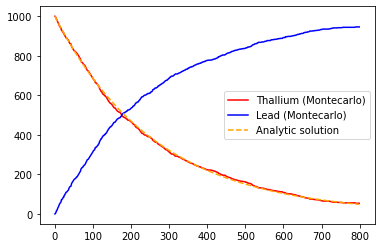

In [2]:
#First method

time = 800
dt = 1
sample_size = 1000
half_life = 3.052*60
atoms = np.zeros(sample_size)

# These two will store how many atoms have/have not decayed at each point in time.
thallium = np.zeros(time)
lead = np.zeros(time)

def prob(dt):
    half_life = 3.052*60
    return 1 - 2 ** (-dt/half_life)

analytic = sample_size*2**(-np.arange(time)/half_life)

for i in range(time):
    
    lead[i] = np.sum(atoms == 1)
    thallium[i] = np.sum(atoms == 0)
    
    for j in range(sample_size):
        if np.random.random() <= prob(dt):
            if atoms[j] == 0:
                atoms[j] = 1

plt.plot(range(time), thallium, color = 'red', label = 'Thallium (Montecarlo)')
plt.plot(range(time), lead, color = 'blue', label = 'Lead (Montecarlo)')  
plt.plot(range(time), analytic, color = 'orange', ls = '--', label = 'Analytic solution')
plt.legend()
plt.show()

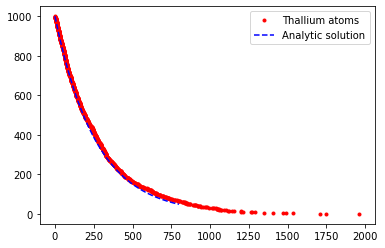

In [3]:
from scipy.stats import expon

#Second method

half_life = 3.052*60
decay_times = expon.rvs(loc = 0, scale = half_life/np.log(2), size = 1000)
decay_times = np.sort(decay_times)

th_sample = np.arange(1000)
th_sample = th_sample[::-1]
#print(decay_times)
plt.plot(decay_times, th_sample, marker = '.', color = 'red', ls = '', label = 'Thallium atoms')
plt.plot(range(time), analytic, color = 'blue', ls = '--', label = 'Analytic solution')
plt.legend()
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [4]:
# The experiment has a rotational symmetry: the impact parameter only depends on the distance to the center of the atom. This means that the beam being a distance b to the left/right of the atom should end up scattering at a similar angle as the beam a distance b under/over the atom. This means we can simplify the simulation to just be a two-dimensional problem.

no_particles = int(1e6)

Z = 79
E = 7.7e6*1.6e-19
a_0 = (4*pi*epsilon_0*hbar**2)/(m_e*elementary_charge**2)

beam_pos = stats.norm.rvs(loc = 0, scale = a_0/100, size = no_particles)
tan_theta_2 = Z*elementary_charge**2/(2*pi*epsilon_0*E*beam_pos)
angles = 2*np.arctan(tan_theta_2)

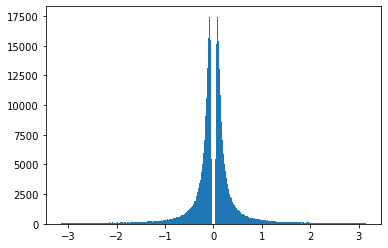

In [5]:
#Computing a histogram of the distribution of angles. I will calculate the fraction in the next cell.
counts, bins, patches = plt.hist(angles, bins = 'fd')

In [6]:
#The histogram makes sense: We aren't expected to find much in the angle closer to zero: That corresponds to a particle going through the gold nucleus mostly unscattered. Particles colliding with the nucleus head-on are scattered directly backwards.
#Onto finding the fractions

bounce_back = len(angles[abs(angles) > (pi/2)])/no_particles
bounce_back

0.04462

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function
$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [7]:
from scipy.stats import uniform as uni #random.uniform includes the endpoint, while np.random.uniform might not.

def func(x):
    import numpy as np
    return np.sin(1/(x*(2-x)))**2

def MC_integrate(func, N, low, high):
    count = 0
    for i in range(N):
        x = uni.rvs(loc = 0, scale = 2) # rvs(loc, scale) draws from the interval [loc, loc+scale]
        y = uni.rvs(loc = 0, scale = 1)
        if y <= func(x): count += 1
    integral = (high - low)*count/N
    return integral

print('Hit and miss method {:.5f}'.format(MC_integrate(func, 100000, 0, 2)))

def MC_mv_int(func, N, low, high):
    Sum = 0
    for i in range(N):
        x = uni.rvs(loc = low, scale = high)
        y = func(x)
        Sum += y
    integral = (high-low)/N*Sum
    return integral
print('Mean value method {:.5f}'.format(MC_mv_int(func, 100000, 0, 2)))

Hit and miss method 1.45400
Mean value method 1.44881


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [8]:
def circle(x):
    return 1 if (np.sum(x**2) <= 1) else 0
#This function works for a position vector x, which can be generalized. We can provide f(x) with a n-tuple, list or 1darray with n entries.

def hit_miss_circle(N, f, dims):
    N_in = 0
    total = 0
    for i in range(N):
        point = uni.rvs(loc = -1, scale = 2, size = dims) # size represents the dimension of the position vector.
        if f(point) == 1: N_in += 1
        total += 1
    integral = (1-(-1))**dims*N_in/total 
    return integral
    
#We'll compare with the volume of the n-sphere, which is given by the following
def n_volume(dims):
    '''
    The formula for the closed form of the volume of a unit n-ball, taken from wikipedia.
    '''
    from math import gamma
    import numpy as np
    
    return np.pi**(dims/2)/gamma(dims/2 + 1)

dims = [2, 10]
N = int(1e5)

for i in dims:
    print('Monte carlo in {} dims is {:.5f}'.format(i, hit_miss_circle(N, circle, i)))
    print('Real value in {} dims is {:.5f}'.format(i, n_volume(i)))

Monte carlo in 2 dims is 3.13720
Real value in 2 dims is 3.14159
Monte carlo in 10 dims is 2.65216
Real value in 10 dims is 2.55016


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [10]:
from scipy.stats import powerlaw

def func(x):
    return 1/(np.sqrt(x)*(np.e**x + 1))

weight = powerlaw(a = 0.5) #powerlaw gives a pdf of a*x^(a-1), so I'll multiply the pdf by 2 to normalize later
w_int = 2 #for w(x) = 1/sqrt(x) between 0 and 1, the integral is simple.

def im_sam_MC(func, weight_prob, w_integral, N, low, high):
    import numpy as np

    x = np.linspace(low, high, N)
    
    x_dist = weight_prob.rvs(size = N)
    w_dist = 2*weight_prob.pdf(x_dist) #multiplying by 2 to normalize
    f = func(x_dist)
    
    integral = np.sum(f/w_dist)*w_integral/N
    return integral

im_sam_MC(func, weight, w_int, 1000000, 0, 1)

0.8391581191847833